In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas
import matplotlib.pyplot as plt
from google.colab import drive
from torch.utils.data import Dataset

In [2]:
#구글 드라이브 연결
drive.mount('./mount')

Mounted at ./mount


In [3]:
def generate_random(size):
    random_data = torch.rand(size).cuda()
    return random_data

## 판별기 네트워크 클래스

In [4]:
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(784, 200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 1),
        nn.Sigmoid()
    ).cuda()
    
    self.loss_function = nn.BCELoss().cuda()
    self.optimizer = optim.Adam(self.parameters(), lr=0.0001)

    self.counter = 0
    self.progress = []

    pass
  
  def forward(self, inputs):
    return self.model(inputs)

  def train(self, inputs, targets):

    outputs = self.forward(inputs)

    loss = self.loss_function(outputs, targets)

    self.counter+=1
    if self.counter%10==0:
      self.progress.append(loss.item())

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()  
    pass
 
  def plot_progress(self):

    df = pandas.DataFrame(self.progress)
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    pass
  pass

## 생성자 클래스

In [5]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(100, 200),
        nn.LeakyReLU(0.02),

        nn.LayerNorm(200),

        nn.Linear(200, 784),
        nn.Sigmoid()
    ).cuda()
    self.optimizer = optim.Adam(self.parameters(), lr=0.0001)

    self.counter = 0
    self.progress = []

    pass
  
  def forward(self, inputs):
    return self.model(inputs)

  def train(self, D, inputs, targets):
    
    gen = self.forward(inputs)
    outputs = D.forward(gen)

    loss = D.loss_function(outputs, targets)

    self.counter+=1
    if self.counter%10==0:
      self.progress.append(loss.item())
   
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    pass
  pass
  
  def plot_progress(self):

    df = pandas.DataFrame(self.progress)
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
    pass
  pass

## 데이터 리더 클래스

In [6]:
class read_data(Dataset):

  def __init__(self, csv_file):

    self.data = pandas.read_csv(csv_file)
    pass

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):

    label = self.data.iloc[index, 0]
    image_values = torch.cuda.FloatTensor(self.data.iloc[index,1:].values)/255.0
    
    return label, image_values

  def show_data(self, index):
    plt.imshow(self.data.iloc[index,1:].values.reshape(28,28), cmap='Blues')
    pass

## 데이터 불러오기 & 데이터 확인

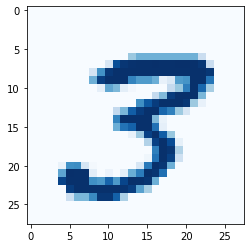

In [7]:
train_data = read_data('mount/My Drive/Colab Notebooks/mnist_data/train_60000.csv')
train_data.show_data(202)

## Train

### 생성자, 판별기 생성

In [8]:
D = Discriminator()
G = Generator()

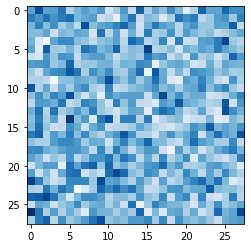

In [9]:
output = G.forward(torch.randn(100).cuda())

img = output.cpu().detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

### 생성자, 발별기 훈련

In [10]:
%%time
for i in range(4):

  for label, img_val in train_data:

    # 판별기 훈련

    D.train(img_val.cuda(), torch.cuda.FloatTensor([1.0]))

    # 생성자로 생성한 데이터로 판별기 훈련
    D.train(G.forward(torch.randn(100).cuda().detach()), torch.cuda.FloatTensor([0.0]))

    # 생성자 훈련
    G.train(D,  torch.randn(100).cuda(), torch.cuda.FloatTensor([1.0]))

CPU times: user 22min 13s, sys: 35 s, total: 22min 48s
Wall time: 22min 38s


## 손실값 확인

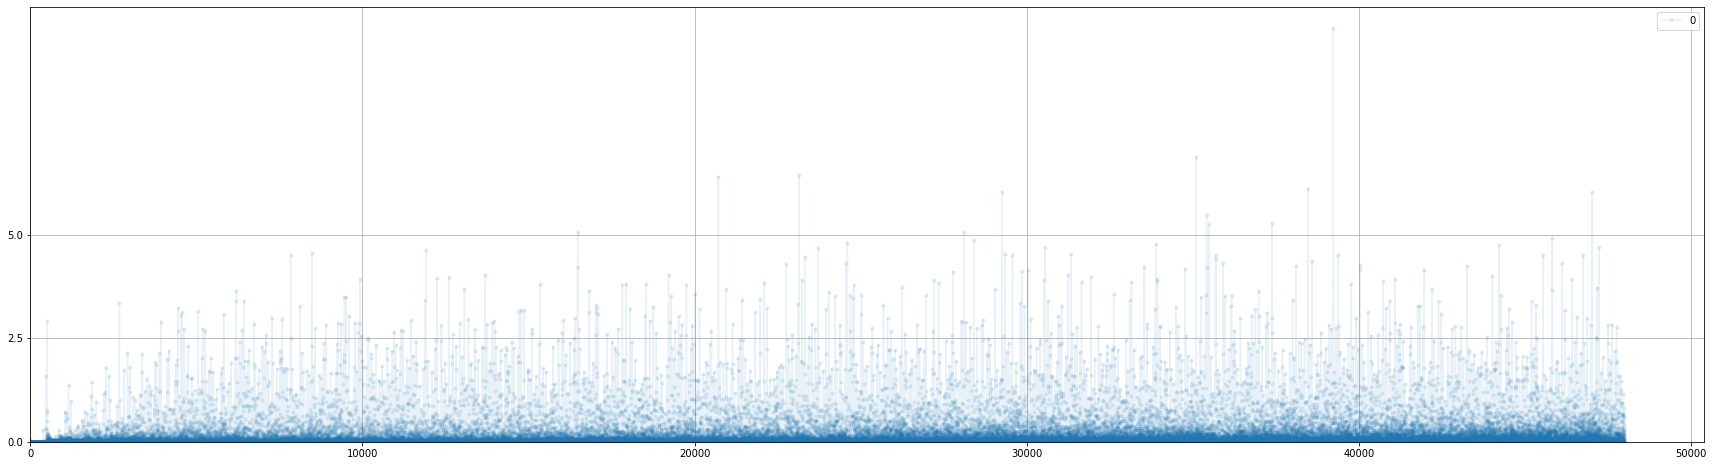

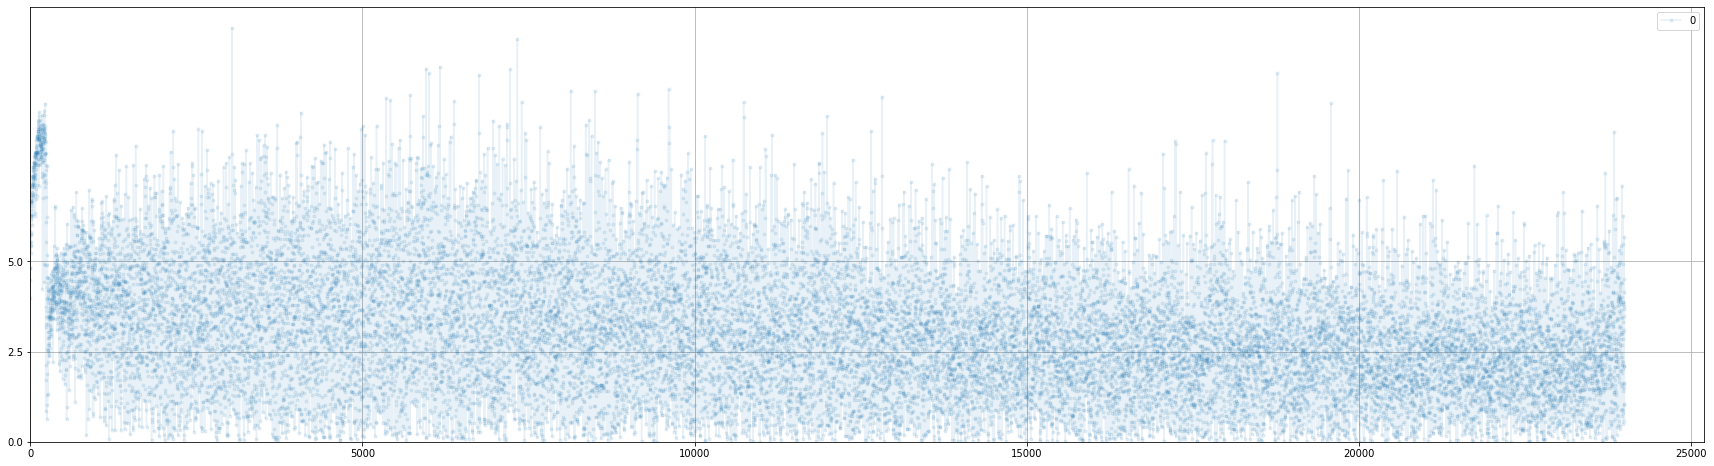

In [11]:
df = pandas.DataFrame(D.progress)
df.plot(xlim=(0.0), ylim=(0.0), figsize=(30,8), alpha=0.1, marker='.', grid=True, yticks=(0.0, 2.5, 5.0))
df = pandas.DataFrame(G.progress)
df.plot(xlim=(0.0), ylim=(0.0), figsize=(30,8), alpha=0.1, marker='.', grid=True, yticks=(0.0, 2.5, 5.0))

## 생성자로 데이터 생성

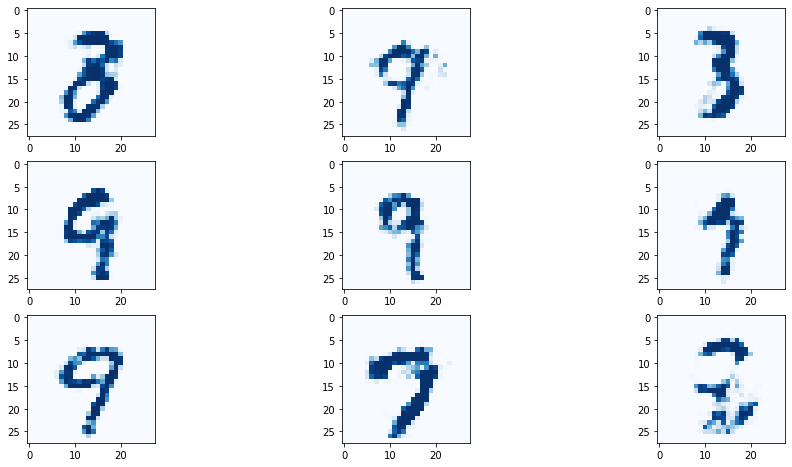

In [13]:
f, axarr = plt.subplots(3,3, figsize=(16,8))
for i in range(3):
  for j in range(3):
    img_val = G.forward(torch.randn(100).cuda()).cpu().detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img_val, interpolation='none', cmap='Blues')
    pass
pass